We now proceed to creating a matched dataset from our exported EMR visit data, matching CDI cases to controls using the propensity scores calculated in the previous notebook with `glmnet`. For propensity score matching (PSM), we employ the `MatchIt` package.

The users' guide to `MatchIt` is found here: http://r.iq.harvard.edu/docs/matchit/2.4-20/

In [1]:
library(glmnet)
library(MatchIt)
load(file="data/analysis_3.RData")
load(file="data/analysis_3_glmnet.RData")
#load(file="data/analysis_3_matchit.all.RData")  # Loads data from a prior run, so steps can be skipped
options(jupyter.plot_mimetypes = "image/svg+xml") 
ls()

Warning message:
“package ‘glmnet’ was built under R version 3.2.4”Loading required package: Matrix
Warning message:
“package ‘Matrix’ was built under R version 3.2.5”Loading required package: foreach
Loaded glmnet 2.0-5

Loading required package: MASS


[1] "alpha"                       "alphas"                     
 [3] "cvfit.cdi_dx"                "cvfit.cdi_union"            
 [5] "cvfit.cdtox_all"             "cvfit.cdtox_all.CA"         
 [7] "cvfit.cdtox_all.HA_early"    "cvfit.cdtox_all.HA_late"    
 [9] "cvfit.cdtox_eia"             "cvfit.cdtox_pcr"            
[11] "cvfits.cdi_dx"               "df"                         
[13] "dx.df"                       "eligible.cdtox_all.CA"      
[15] "eligible.cdtox_all.HA_early" "eligible.cdtox_all.HA_late" 
[17] "foldid"                      "foldid.cdtox_all.CA"        
[19] "foldid.cdtox_all.HA_early"   "foldid.cdtox_all.HA_late"   
[21] "foldid.cdtox_eia"            "foldid.cdtox_pcr"           
[23] "mat4"                        "mat4.no_cdi_equivs"

We quickly check that any pernicious misaligned `rownames` as a result of pruning outlier or incomplete data do not exist (`rownames` should match the row indices for the following analysis to work). `MatchIt` outputs everything in terms of `rownames`.

In [3]:
nrow(df)
tail(rownames(df))

[1] 171938

[1] "171933" "171934" "171935" "171936" "171937" "171938"

Review the unmatched case cohort sizes.

In [4]:
sum(df$cdi_dx == 'Y')

[1] 582

In [5]:
sum(df$cdtox_eia_positive == 'Y')

[1] 324

In [6]:
sum(df$cdtox_pcr_positive == 'Y')

[1] 620

In [7]:
sum(df$cdtox_eia_positive == 'Y' | df$cdtox_pcr_positive == 'Y')

[1] 944

In [8]:
sum(df$cdi_dx == 'Y' | df$cdtox_eia_positive == 'Y' | df$cdtox_pcr_positive == 'Y')

[1] 1092

The following is a quantitative visualization of overlaps/intersections between all of these case cohorts, using the [UpSetR package](https://github.com/hms-dbmi/UpSetR).

For simplicity, we chose to redraw this manually as a Venn diagram in eFigure 2.

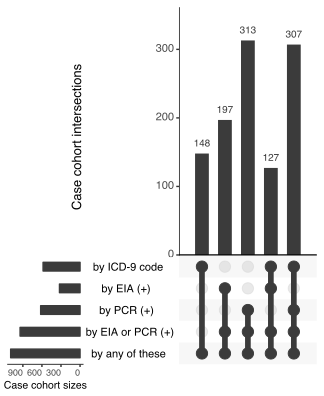

In [92]:
require(UpSetR)
options(jupyter.plot_mimetypes = "image/svg+xml") 
options(repr.plot.width=4.5, repr.plot.height=5.5)

df.sets <- data.frame("by ICD-9 code" = as.integer(df$cdi_dx == 'Y'),
                      "by EIA (+)" = as.integer(df$cdtox_eia_positive == 'Y'),
                      "by PCR (+)" = as.integer(df$cdtox_pcr_positive == 'Y'),
                      "by EIA or PCR (+)" = as.integer(df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y'),
                      "by any of these" = as.integer(df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y' | df$cdi_dx == 'Y'),
                      check.names=FALSE)
#pdf("data/analysis_3_case_set_intersections.pdf", width=4.5, height=5.5)
upset(df.sets, sets=rev(colnames(df.sets)), keep.order=TRUE, decreasing=c(FALSE, FALSE), mb.ratio=c(0.65, 0.35),
      point.size = 4.5, line.size = 2, mainbar.y.label = "Case cohort intersections", sets.x.label = "Case cohort sizes", 
      text.scale=c(1.5, 1.5, 1.2, 1.2, 1.5, 1.5))
#dev.off()

The age intervals that we chose for this study. Note that all ages over 90 are right clipped at 90, so the upper bound of 120 is meaningless--it's effectively [90, Infinity).

In [9]:
df$age_bucket <- cut(df$age, breaks=c(18, 30, 45, 60, 75, 90, 120), right=FALSE)

Summarize age and gender in the full unmatched dataset.

In [10]:
options(digits=5)
print(summary(df$gender))
print(summary(df$gender) / nrow(df) * 100)
summary(df$gender)

       Female Indeterminant          Male NOT AVAILABLE 
       101964             2         69971             1 
       Female Indeterminant          Male NOT AVAILABLE 
   59.3027719     0.0011632    40.6954833     0.0005816 


Female Indeterminant          Male NOT AVAILABLE 
       101964             2         69971             1

In [11]:
summary(df$age_bucket)

[18,30)  [30,45)  [45,60)  [60,75)  [75,90) [90,120) 
   22344    39003    37234    43946    26167     3244

In [12]:
round(summary(df$age_bucket) / nrow(df), 2)

[18,30)  [30,45)  [45,60)  [60,75)  [75,90) [90,120) 
    0.13     0.23     0.22     0.26     0.15     0.02

# Start matching

## 1a. `cdi_dx = 'Y'` cases

In [161]:
distances.cdi_dx <- as.vector(predict(cvfit.cdi_dx, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdi_dx)

 num [1:171938] 0.00249 0.00238 0.00194 0.00291 0.00205 ...


In [162]:
df$cdi_dx_bool <- df$cdi_dx == 'Y'

We have to delete the `cd_toxin_after` column because MatchIt doesn't allow any columns with missing values.

In [163]:
df.no_toxin_after <- df
df.no_toxin_after$cdtox_positive_after = NULL

In [164]:
ptm <- proc.time()
m.out.cdi_dx <- matchit(cdi_dx_bool ~ age_bucket + gender, 
                        data=df.no_toxin_after, distance=logit(distances.cdi_dx), ratio=1, exact=c("gender", "age_bucket"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
164.828  14.585 179.603 

In [165]:
m.out.cdi_dx


Call: 
matchit(formula = cdi_dx_bool ~ age_bucket + gender, data = df.no_toxin_after, 
    distance = logit(distances.cdi_dx), ratio = 1, exact = c("gender", 
        "age_bucket"), caliper = 0.2)

Sample sizes:
          Control Treated
All        171356     582
Matched       489     489
Unmatched  170867      93
Discarded       0       0


In [166]:
head(m.out.cdi_dx$match.matrix)

,1
255,135716
675,100975
895,141641
914,171139
989,103189
1794,150355


In [274]:
m.out.cdi_dx.controls <- as.numeric(m.out.cdi_dx$match.matrix[!is.na(m.out.cdi_dx$match.matrix)])
m.out.cdi_dx.cases <- as.numeric(rownames(m.out.cdi_dx$match.matrix)[!is.na(m.out.cdi_dx$match.matrix)])
length(m.out.cdi_dx.cases)
length(m.out.cdi_dx.controls)
length(m.out.cdi_dx.cases) / length(m.out.cdi_dx$match.matrix)

[1] 489

[1] 489

[1] 0.84021

Create a second matched set of controls *to the matched controls* (as a test of the matching process itself--matching by itself shouldn't change the outcome variable).

In [168]:
df.no_toxin_after$cdi_dx_matched <- FALSE
df.no_toxin_after$cdi_dx_matched[m.out.cdi_dx.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdi_dx <- matchit(cdi_dx_matched ~ age_bucket + gender + cdi_dx, 
                          data=df.no_toxin_after, distance=logit(distances.cdi_dx), ratio=1, exact=c("gender", "age_bucket", "cdi_dx"),
                          caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 187.44   15.25  203.41 

In [169]:
m.m.out.cdi_dx.controls <- as.numeric(m.m.out.cdi_dx$match.matrix[!is.na(m.m.out.cdi_dx$match.matrix)])
m.m.out.cdi_dx


Call: 
matchit(formula = cdi_dx_matched ~ age_bucket + gender + cdi_dx, 
    data = df.no_toxin_after, distance = logit(distances.cdi_dx), 
    ratio = 1, exact = c("gender", "age_bucket", "cdi_dx"), caliper = 0.2)

Sample sizes:
          Control Treated
All        171449     489
Matched       475     475
Unmatched  170974      14
Discarded       0       0


The following creates visualizations of the density distributions for propensity scores in each of the cohorts (matched, unmatched, etc.)

In [170]:
library(Hmisc)
require(cowplot)
options(digits=1)

matchit.pal <- c("red", "blue", "orange", "gray60")

matchit.freqpoly <- function(df.pscores, title, pdf=FALSE) {
    options(repr.plot.width=8, repr.plot.height=4)
    df.pscores$set <- factor(df.pscores$set, levels = levels(df.pscores$set)[c(2,3,4,1)])
    gg <- ggplot(df.pscores, aes(x=propensity_score, y=..density.., color=set)) +
        geom_freqpoly(binwidth=0.05) + 
        scale_color_manual(values = matchit.pal) +
        scale_x_log10("propensity score")
    if (pdf) { save_plot(paste0("data/analysis_3_match-", title, "-freqpoly.pdf"), gg, base_aspect_ratio = 1.3) }
    gg
}

matchit.density <- function(df.pscores, title, pdf=TRUE) {
    options(repr.plot.width=6, repr.plot.height=4)
    df.pscores$logit_pscore <- logit(df.pscores$propensity_score)
    df.pscores$set <- factor(df.pscores$set, levels = levels(df.pscores$set)[c(2,3,4,1)])
    gg <- ggplot(df.pscores, aes(logit_pscore, color=set)) +
        geom_density(aes(linetype=set)) +
        scale_color_manual(values = matchit.pal) +
        scale_linetype_manual(values = c(1, 2, 4, 3)) + 
        scale_x_continuous("logit(propensity score)") + 
        theme(legend.position=c(0.7, 0.8), legend.title=element_blank())
    if (pdf) { save_plot(paste0("data/analysis_3_match-", title, "-density.pdf"), gg, base_height=3, base_aspect_ratio=1.3) }
    gg
}

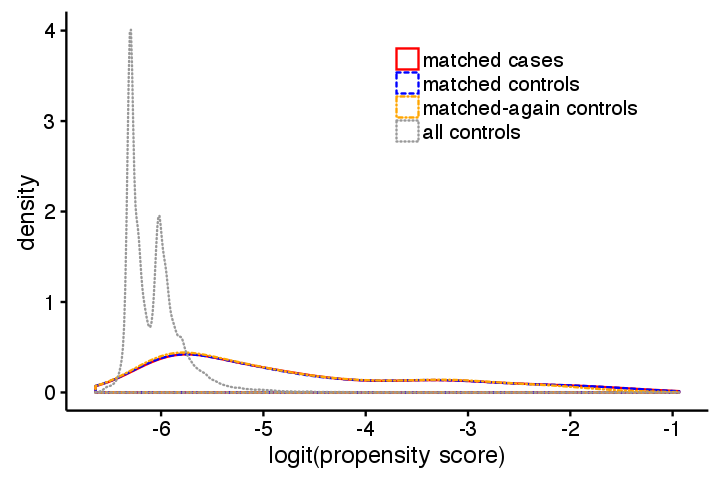

In [171]:
pscores.cdi_dx.all_controls <- distances.cdi_dx[!df$cdi_dx_bool & df$started_cdtox_pcr == 'N']
pscores.cdi_dx.m_controls <- distances.cdi_dx[m.out.cdi_dx.controls]
pscores.cdi_dx.m_m_controls <- distances.cdi_dx[m.m.out.cdi_dx.controls]
pscores.cdi_dx.cases <- distances.cdi_dx[m.out.cdi_dx.cases]

pscores.cdi_dx <- data.frame(
    propensity_score = c(pscores.cdi_dx.all_controls, pscores.cdi_dx.cases, 
                         pscores.cdi_dx.m_controls, pscores.cdi_dx.m_m_controls),
    set = c(rep("all controls", length(pscores.cdi_dx.all_controls)), 
            rep("matched cases", length(pscores.cdi_dx.cases)), 
            rep("matched controls", length(pscores.cdi_dx.m_controls)),
            rep("matched-again controls", length(pscores.cdi_dx.m_m_controls)))
)

matchit.density(pscores.cdi_dx, "cdi_dx")
#matchit.freqpoly(pscores.cdi_dx, "cdi_dx")

## 1b. `cdtox_eia_positive = 'Y'` cases

In [172]:
distances.cdtox_eia <- as.vector(predict(cvfit.cdtox_eia, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_eia)

 num [1:171938] 0.00348 0.00275 0.00204 0.00393 0.00197 ...


In [173]:
df.no_toxin_after$cdtox_eia_bool <- df$cdtox_eia_bool <- df$cdtox_eia_positive == 'Y'

In [174]:
ptm <- proc.time()
m.out.cdtox_eia <- matchit(cdtox_eia_bool ~ age_bucket + gender + started_cdtox_pcr, 
                           data=df.no_toxin_after, distance=logit(distances.cdtox_eia), ratio=1,
                           exact=c("gender", "age_bucket", "started_cdtox_pcr"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
    133      11     144 

In [175]:
options(digits=3)
m.out.cdtox_eia


Call: 
matchit(formula = cdtox_eia_bool ~ age_bucket + gender + started_cdtox_pcr, 
    data = df.no_toxin_after, distance = logit(distances.cdtox_eia), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171614     324
Matched       274     274
Unmatched  171340      50
Discarded       0       0


In [176]:
head(m.out.cdtox_eia$match.matrix)

,1
151,28025
223,55910
255,NA
361,31143
675,9721
902,56156


In [275]:
m.out.cdtox_eia.controls <- as.numeric(m.out.cdtox_eia$match.matrix[!is.na(m.out.cdtox_eia$match.matrix)])
m.out.cdtox_eia.cases <- as.numeric(rownames(m.out.cdtox_eia$match.matrix)[!is.na(m.out.cdtox_eia$match.matrix)])
length(m.out.cdtox_eia.cases) / length(m.out.cdtox_eia$match.matrix)

[1] 0.84568

In [178]:
df.no_toxin_after$cdtox_eia_matched <- FALSE
df.no_toxin_after$cdtox_eia_matched[m.out.cdtox_eia.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_eia <- matchit(cdtox_eia_matched ~ age_bucket + gender + started_cdtox_pcr + cdtox_eia_positive, 
                             data=df.no_toxin_after, distance=logit(distances.cdtox_eia), ratio=1, 
                             exact=c("gender", "age_bucket", "started_cdtox_pcr", "cdtox_eia_positive"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  140.6    10.7   151.4 

In [179]:
m.m.out.cdtox_eia.controls <- as.numeric(m.m.out.cdtox_eia$match.matrix[!is.na(m.m.out.cdtox_eia$match.matrix)])
m.m.out.cdtox_eia


Call: 
matchit(formula = cdtox_eia_matched ~ age_bucket + gender + started_cdtox_pcr + 
    cdtox_eia_positive, data = df.no_toxin_after, distance = logit(distances.cdtox_eia), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr", 
        "cdtox_eia_positive"), caliper = 0.2)

Sample sizes:
          Control Treated
All        171664     274
Matched       269     269
Unmatched  171395       5
Discarded       0       0


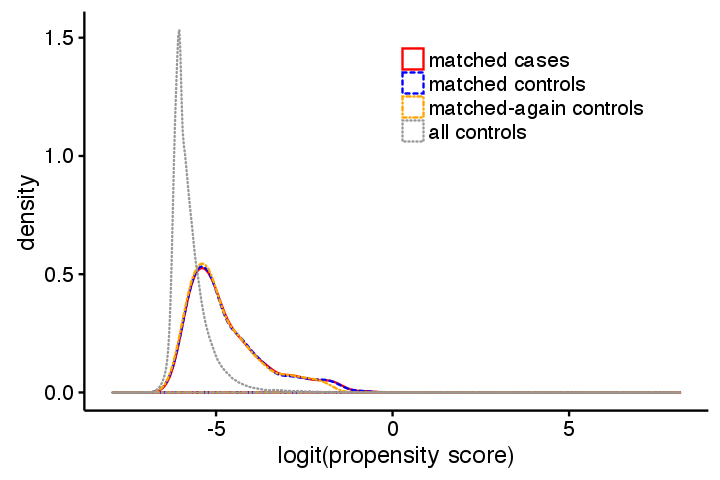

In [180]:
pscores.cdtox_eia.all_controls <- distances.cdtox_eia[!df$cdtox_eia_bool]
pscores.cdtox_eia.m_controls <- distances.cdtox_eia[m.out.cdtox_eia.controls]
pscores.cdtox_eia.m_m_controls <- distances.cdtox_eia[m.m.out.cdtox_eia.controls]
pscores.cdtox_eia.cases <- distances.cdtox_eia[m.out.cdtox_eia.cases]

pscores.cdtox_eia <- data.frame(
    propensity_score = c(pscores.cdtox_eia.all_controls, pscores.cdtox_eia.cases, 
                         pscores.cdtox_eia.m_controls, pscores.cdtox_eia.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_eia.all_controls)), 
            rep("matched cases", length(pscores.cdtox_eia.cases)), 
            rep("matched controls", length(pscores.cdtox_eia.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_eia.m_m_controls)))
)

matchit.density(pscores.cdtox_eia, "cdtox_eia")
#matchit.freqpoly(pscores.cdtox_eia, "cdtox_eia")

## 1c. `cdtox_pcr_positive = 'Y'`

In [181]:
distances.cdtox_pcr <- as.vector(predict(cvfit.cdtox_pcr, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_pcr)

 num [1:171938] 0.00338 0.00318 0.00272 0.00345 0.00305 ...


In [182]:
df.no_toxin_after$cdtox_pcr_bool <- df$cdtox_pcr_bool <- df$cdtox_pcr_positive == 'Y'

In [183]:
ptm <- proc.time()
m.out.cdtox_pcr <- matchit(cdtox_pcr_bool ~ age_bucket + gender + started_cdtox_pcr, 
                           data=df.no_toxin_after, distance=logit(distances.cdtox_pcr), ratio=1,
                           exact=c("gender", "age_bucket", "started_cdtox_pcr"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  242.3    19.6   262.1 

In [184]:
options(digits=3)
m.out.cdtox_pcr


Call: 
matchit(formula = cdtox_pcr_bool ~ age_bucket + gender + started_cdtox_pcr, 
    data = df.no_toxin_after, distance = logit(distances.cdtox_pcr), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171318     620
Matched       493     493
Unmatched  170825     127
Discarded       0       0


In [185]:
head(m.out.cdtox_pcr$match.matrix)

,1
66664,6445
73593,2423
73749,73016
73909,47762
74073,113220
74209,NA


In [276]:
m.out.cdtox_pcr.controls <- as.numeric(m.out.cdtox_pcr$match.matrix[!is.na(m.out.cdtox_pcr$match.matrix)])
m.out.cdtox_pcr.cases <- as.numeric(rownames(m.out.cdtox_pcr$match.matrix)[!is.na(m.out.cdtox_pcr$match.matrix)])
length(m.out.cdtox_pcr.cases) / length(m.out.cdtox_pcr$match.matrix)

[1] 0.79516

In [187]:
df.no_toxin_after$cdtox_pcr_matched <- FALSE
df.no_toxin_after$cdtox_pcr_matched[m.out.cdtox_pcr.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_pcr <- matchit(cdtox_pcr_matched ~ age_bucket + gender + started_cdtox_pcr + cdtox_pcr_positive, 
                             data=df.no_toxin_after, distance=logit(distances.cdtox_pcr), ratio=1, 
                             exact=c("gender", "age_bucket", "started_cdtox_pcr", "cdtox_pcr_positive"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  247.6    19.4   267.2 

In [188]:
m.m.out.cdtox_pcr.controls <- as.numeric(m.m.out.cdtox_pcr$match.matrix[!is.na(m.m.out.cdtox_pcr$match.matrix)])
m.m.out.cdtox_pcr


Call: 
matchit(formula = cdtox_pcr_matched ~ age_bucket + gender + started_cdtox_pcr + 
    cdtox_pcr_positive, data = df.no_toxin_after, distance = logit(distances.cdtox_pcr), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr", 
        "cdtox_pcr_positive"), caliper = 0.2)

Sample sizes:
          Control Treated
All        171445     493
Matched       458     458
Unmatched  170987      35
Discarded       0       0


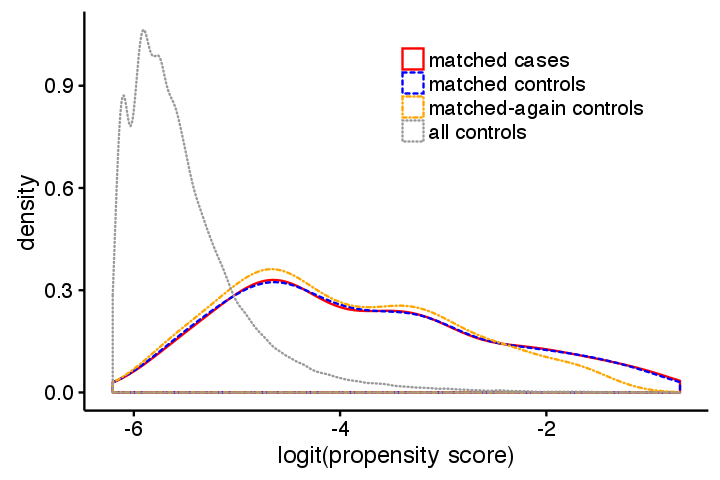

In [189]:
pscores.cdtox_pcr.all_controls <- distances.cdtox_pcr[!df$cdtox_pcr_bool & df$started_cdtox_pcr == 'Y']
pscores.cdtox_pcr.m_controls <- distances.cdtox_pcr[m.out.cdtox_pcr.controls]
pscores.cdtox_pcr.m_m_controls <- distances.cdtox_pcr[m.m.out.cdtox_pcr.controls]
pscores.cdtox_pcr.cases <- distances.cdtox_pcr[m.out.cdtox_pcr.cases]

pscores.cdtox_pcr <- data.frame(
    propensity_score = c(pscores.cdtox_pcr.all_controls, pscores.cdtox_pcr.cases, 
                         pscores.cdtox_pcr.m_controls, pscores.cdtox_pcr.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_pcr.all_controls)), 
            rep("matched cases", length(pscores.cdtox_pcr.cases)), 
            rep("matched controls", length(pscores.cdtox_pcr.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_pcr.m_m_controls)))
)

matchit.density(pscores.cdtox_pcr, "cdtox_pcr")
#matchit.freqpoly(pscores.cdtox_pcr, "cdtox_pcr")

## 1d. either 1b OR 1c

In [190]:
distances.cdtox_all <- as.vector(predict(cvfit.cdtox_all, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_all)

 num [1:171938] 0.00405 0.003 0.00223 0.0036 0.0024 ...


In [191]:
df.no_toxin_after$cdtox_all_bool <- df$cdtox_all_bool <- df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y'

In [192]:
ptm <- proc.time()
m.out.cdtox_all <- matchit(cdtox_all_bool ~ age_bucket + gender + started_cdtox_pcr, 
                           data=df.no_toxin_after, distance=logit(distances.cdtox_all), ratio=1,
                           exact=c("gender", "age_bucket", "started_cdtox_pcr"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  366.8    30.2   397.3 

In [193]:
options(digits=3)
m.out.cdtox_all


Call: 
matchit(formula = cdtox_all_bool ~ age_bucket + gender + started_cdtox_pcr, 
    data = df.no_toxin_after, distance = logit(distances.cdtox_all), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        170994     944
Matched       788     788
Unmatched  170206     156
Discarded       0       0


In [194]:
head(m.out.cdtox_all$match.matrix)

,1
151,38754
223,20795
255,NA
361,14718
675,38166
902,10871


In [277]:
m.out.cdtox_all.controls <- as.numeric(m.out.cdtox_all$match.matrix[!is.na(m.out.cdtox_all$match.matrix)])
m.out.cdtox_all.cases <- as.numeric(rownames(m.out.cdtox_all$match.matrix)[!is.na(m.out.cdtox_all$match.matrix)])
length(m.out.cdtox_all.cases) / length(m.out.cdtox_all$match.matrix)

[1] 0.83475

In [196]:
df.no_toxin_after$cdtox_all_matched <- FALSE
df.no_toxin_after$cdtox_all_matched[m.out.cdtox_all.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_all <- matchit(cdtox_all_matched ~ age_bucket + gender + started_cdtox_pcr + cdtox_all_bool, 
                             data=df.no_toxin_after, distance=logit(distances.cdtox_all), ratio=1, 
                             exact=c("gender", "age_bucket", "started_cdtox_pcr", "cdtox_all_bool"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  369.6    28.7   399.0 

In [197]:
m.m.out.cdtox_all.controls <- as.numeric(m.m.out.cdtox_all$match.matrix[!is.na(m.m.out.cdtox_all$match.matrix)])
m.m.out.cdtox_all


Call: 
matchit(formula = cdtox_all_matched ~ age_bucket + gender + started_cdtox_pcr + 
    cdtox_all_bool, data = df.no_toxin_after, distance = logit(distances.cdtox_all), 
    ratio = 1, exact = c("gender", "age_bucket", "started_cdtox_pcr", 
        "cdtox_all_bool"), caliper = 0.2)

Sample sizes:
          Control Treated
All        171150     788
Matched       749     749
Unmatched  170401      39
Discarded       0       0


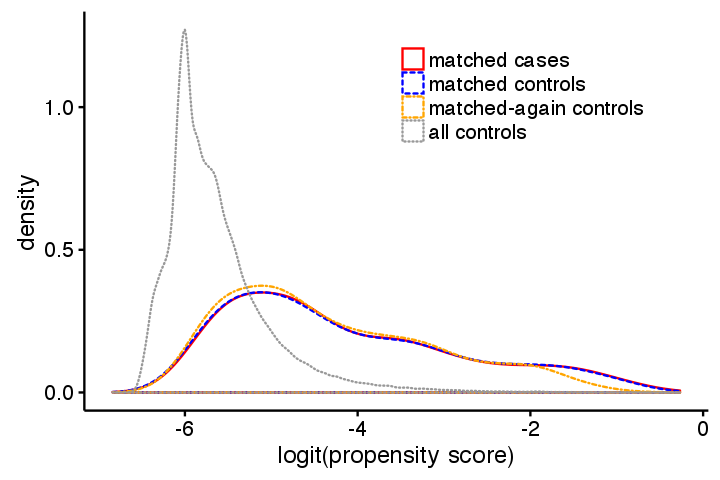

In [198]:
pscores.cdtox_all.all_controls <- distances.cdtox_all[!df$cdtox_all_bool]
pscores.cdtox_all.m_controls <- distances.cdtox_all[m.out.cdtox_all.controls]
pscores.cdtox_all.m_m_controls <- distances.cdtox_all[m.m.out.cdtox_all.controls]
pscores.cdtox_all.cases <- distances.cdtox_all[m.out.cdtox_all.cases]

pscores.cdtox_all <- data.frame(
    propensity_score = c(pscores.cdtox_all.all_controls, pscores.cdtox_all.cases, 
                         pscores.cdtox_all.m_controls, pscores.cdtox_all.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_all.all_controls)), 
            rep("matched cases", length(pscores.cdtox_all.cases)), 
            rep("matched controls", length(pscores.cdtox_all.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_all.m_m_controls)))
)

matchit.density(pscores.cdtox_all, "cdtox_all")
#matchit.freqpoly(pscores.cdtox_all, "cdtox_all")

## 1e. union of 1a, 1b, and 1c

In [199]:
distances.cdi_union <- as.vector(predict(cvfit.cdi_union, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdi_union)

 num [1:171938] 0.00473 0.00369 0.0028 0.00453 0.00294 ...


In [200]:
df.no_toxin_after$cdi_union_bool <- df$cdi_union_bool <- df$cdi_dx_bool | df$cdtox_eia_bool | df$cdtox_pcr_bool

In [201]:
ptm <- proc.time()
m.out.cdi_union <- matchit(cdi_union_bool ~ age_bucket + gender, 
                           data=df.no_toxin_after, distance=logit(distances.cdi_union), ratio=1, exact=c("gender", "age_bucket"),
                           caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  289.3    26.5   316.0 

In [202]:
options(digits=3)
m.out.cdi_union


Call: 
matchit(formula = cdi_union_bool ~ age_bucket + gender, data = df.no_toxin_after, 
    distance = logit(distances.cdi_union), ratio = 1, exact = c("gender", 
        "age_bucket"), caliper = 0.2)

Sample sizes:
          Control Treated
All        170846    1092
Matched       945     945
Unmatched  169901     147
Discarded       0       0


In [203]:
head(m.out.cdi_union$match.matrix)

,1
151,1415
223,112611
255,89860
361,58935
675,112924
895,56415


In [278]:
m.out.cdi_union.controls <- as.numeric(m.out.cdi_union$match.matrix[!is.na(m.out.cdi_union$match.matrix)])
m.out.cdi_union.cases <- as.numeric(rownames(m.out.cdi_union$match.matrix)[!is.na(m.out.cdi_union$match.matrix)])
length(m.out.cdi_union.cases) / length(m.out.cdi_union$match.matrix)

[1] 0.86538

In [205]:
df.no_toxin_after$cdi_union_matched <- FALSE
df.no_toxin_after$cdi_union_matched[m.out.cdi_union.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdi_union <- matchit(cdi_union_matched ~ age_bucket + gender + cdi_union_bool, 
                             data=df.no_toxin_after, distance=logit(distances.cdi_union), ratio=1, 
                             exact=c("gender", "age_bucket", "cdi_union_bool"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  360.6    29.1   390.1 

In [206]:
m.m.out.cdi_union.controls <- as.numeric(m.m.out.cdi_union$match.matrix[!is.na(m.m.out.cdi_union$match.matrix)])
m.m.out.cdi_union


Call: 
matchit(formula = cdi_union_matched ~ age_bucket + gender + cdi_union_bool, 
    data = df.no_toxin_after, distance = logit(distances.cdi_union), 
    ratio = 1, exact = c("gender", "age_bucket", "cdi_union_bool"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        170993     945
Matched       905     905
Unmatched  170088      40
Discarded       0       0


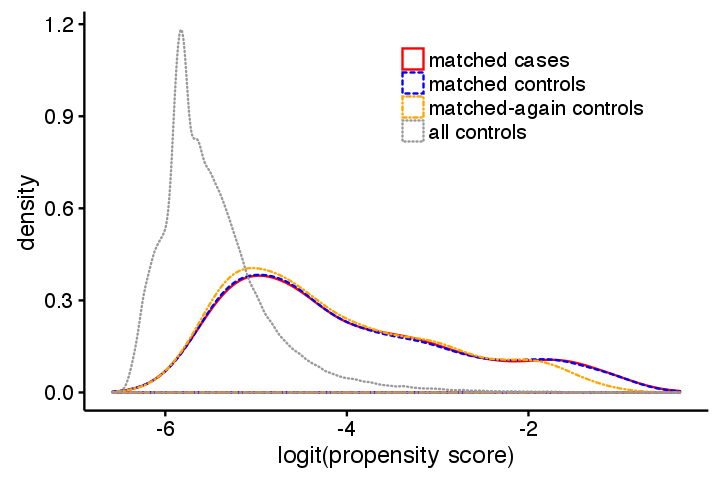

In [207]:
pscores.cdi_union.all_controls <- distances.cdi_union[!df$cdi_union_bool]
pscores.cdi_union.m_controls <- distances.cdi_union[m.out.cdi_union.controls]
pscores.cdi_union.m_m_controls <- distances.cdi_union[m.m.out.cdi_union.controls]
pscores.cdi_union.cases <- distances.cdi_union[m.out.cdi_union.cases]

pscores.cdi_union <- data.frame(
    propensity_score = c(pscores.cdi_union.all_controls, pscores.cdi_union.cases, 
                         pscores.cdi_union.m_controls, pscores.cdi_union.m_m_controls),
    set = c(rep("all controls", length(pscores.cdi_union.all_controls)), 
            rep("matched cases", length(pscores.cdi_union.cases)), 
            rep("matched controls", length(pscores.cdi_union.m_controls)),
            rep("matched-again controls", length(pscores.cdi_union.m_m_controls)))
)

matchit.density(pscores.cdi_union, "cdi_union")
#matchit.freqpoly(pscores.cdi_union, "cdi_union")

## 2a. (1b OR 1c) AND `cdtox_positive_after < 3`

In [208]:
distances.cdtox_all.CA <- as.vector(predict(cvfit.cdtox_all.CA, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_all.CA)

 num [1:171938] 0.001279 0.001113 0.000759 0.001269 0.00086 ...


We forbid matching with any cdtox positive result that is NOT before 3 days.

In [209]:
cdtox_all_positives <- df$cdtox_pcr_positive == 'Y' | df$cdtox_eia_positive == 'Y'
sum(cdtox_all_positives)
sum(cdtox_all_positives & df$cdtox_positive_after < 3)

matchable.cdtox_all.CA <- !(cdtox_all_positives & !(df$cdtox_positive_after < 3))
sum(matchable.cdtox_all.CA)
sum(matchable.cdtox_all.CA & (cdtox_all_positives & df$cdtox_positive_after < 3))

[1] 944

[1] 348

[1] 171342

[1] 348

In [210]:
df.no_toxin_after$cdtox_all.CA.bool <- df$cdtox_all.CA.bool <- cdtox_all_positives & df$cdtox_positive_after < 3
df.no_toxin_after$matchable.cdtox_all.CA <- matchable.cdtox_all.CA

In [211]:
ptm <- proc.time()
m.out.cdtox_all.CA <- matchit(cdtox_all.CA.bool ~ age_bucket + gender + matchable.cdtox_all.CA, 
                              data=df.no_toxin_after, distance=logit(distances.cdtox_all.CA), ratio=1,
                              exact=c("gender", "age_bucket", "matchable.cdtox_all.CA"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
  133.9    10.5   144.5 

In [212]:
options(digits=3)
m.out.cdtox_all.CA


Call: 
matchit(formula = cdtox_all.CA.bool ~ age_bucket + gender + matchable.cdtox_all.CA, 
    data = df.no_toxin_after, distance = logit(distances.cdtox_all.CA), 
    ratio = 1, exact = c("gender", "age_bucket", "matchable.cdtox_all.CA"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171590     348
Matched       254     254
Unmatched  171336      94
Discarded       0       0


In [213]:
head(m.out.cdtox_all.CA$match.matrix)

,1
151,130403
255,NA
1794,71565
1800,135637
1840,130593
1951,163504


In [279]:
m.out.cdtox_all.CA.controls <- as.numeric(m.out.cdtox_all.CA$match.matrix[!is.na(m.out.cdtox_all.CA$match.matrix)])
m.out.cdtox_all.CA.cases <- as.numeric(rownames(m.out.cdtox_all.CA$match.matrix)[!is.na(m.out.cdtox_all.CA$match.matrix)])
length(m.out.cdtox_all.CA.cases) / length(m.out.cdtox_all.CA$match.matrix)

[1] 0.72989

In [215]:
df.no_toxin_after$cdtox_all.CA.matched <- FALSE
df.no_toxin_after$cdtox_all.CA.matched[m.out.cdtox_all.CA.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_all.CA <- matchit(cdtox_all.CA.matched ~ age_bucket + gender + cdtox_all_bool + matchable.cdtox_all.CA, 
                                data=df.no_toxin_after, distance=logit(distances.cdtox_all.CA), ratio=1, 
                                exact=c("gender", "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.CA"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 126.93    8.96  135.98 

In [216]:
m.m.out.cdtox_all.CA.controls <- as.numeric(m.m.out.cdtox_all.CA$match.matrix[!is.na(m.m.out.cdtox_all.CA$match.matrix)])
m.m.out.cdtox_all.CA


Call: 
matchit(formula = cdtox_all.CA.matched ~ age_bucket + gender + 
    cdtox_all_bool + matchable.cdtox_all.CA, data = df.no_toxin_after, 
    distance = logit(distances.cdtox_all.CA), ratio = 1, exact = c("gender", 
        "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.CA"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171684     254
Matched       235     235
Unmatched  171449      19
Discarded       0       0


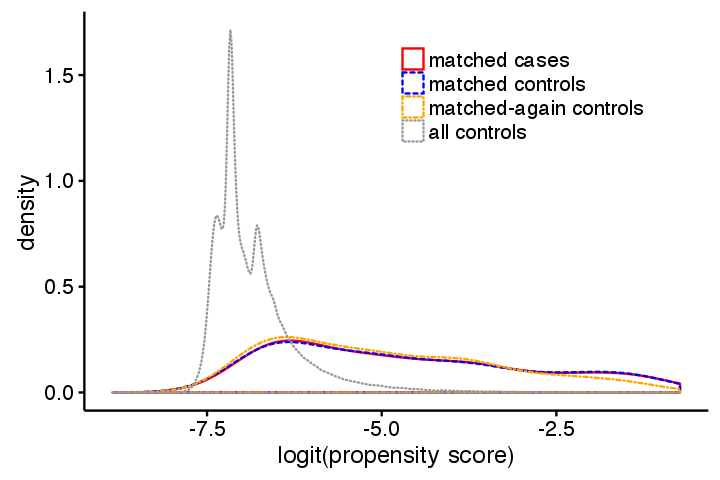

In [217]:
pscores.cdtox_all.CA.all_controls <- distances.cdtox_all.CA[!df$cdtox_all_bool]
pscores.cdtox_all.CA.m_controls <- distances.cdtox_all.CA[m.out.cdtox_all.CA.controls]
pscores.cdtox_all.CA.m_m_controls <- distances.cdtox_all.CA[m.m.out.cdtox_all.CA.controls]
pscores.cdtox_all.CA.cases <- distances.cdtox_all.CA[m.out.cdtox_all.CA.cases]

pscores.cdtox_all.CA <- data.frame(
    propensity_score = c(pscores.cdtox_all.CA.all_controls, pscores.cdtox_all.CA.cases, 
                         pscores.cdtox_all.CA.m_controls, pscores.cdtox_all.CA.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_all.CA.all_controls)), 
            rep("matched cases", length(pscores.cdtox_all.CA.cases)), 
            rep("matched controls", length(pscores.cdtox_all.CA.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_all.CA.m_m_controls)))
)

matchit.density(pscores.cdtox_all.CA, "cdtox_all-CA")
#matchit.freqpoly(pscores.cdtox_all.CA, "cdtox_all-CA")

## 2b. (1b OR 1c) AND `cdtox_positive_after >= 3` AND `cdtox_positive_after < 8`

In [218]:
distances.cdtox_all.HA_early <- as.vector(predict(cvfit.cdtox_all.HA_early, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_all.HA_early)

 num [1:171938] 0.0014 0.000809 0.000772 0.000906 0.000785 ...


We forbid matching with:

- any cdtox positive visit that is NOT within the 3-8 day window.
- any visit (CDI or control) that isn't at least 3 days long.

In [219]:
matchable.cdtox_all.HA_early <- !(
    (cdtox_all_positives & !(df$cdtox_positive_after >= 3 & df$cdtox_positive_after < 8))
    | df$length_of_stay < 3
)
summary(matchable.cdtox_all.HA_early)

   Mode   FALSE    TRUE    NA's 
logical   85764   86174       0 

In [220]:
df.no_toxin_after$cdtox_all.HA_early.bool <- df$cdtox_all.HA_early.bool <- cdtox_all_positives & 
        (df$cdtox_positive_after >= 3 & df$cdtox_positive_after < 8)

df.no_toxin_after$matchable.cdtox_all.HA_early <- matchable.cdtox_all.HA_early

Sanity check: All of the cdtox positive visits within the 3-8 day window should be matchable.

In [221]:
summary(df.no_toxin_after$cdtox_all.HA_early.bool)
summary(df.no_toxin_after$matchable.cdtox_all.HA_early & df.no_toxin_after$cdtox_all.HA_early.bool)

   Mode   FALSE    TRUE    NA's 
logical  171655     283       0 

   Mode   FALSE    TRUE    NA's 
logical  171655     283       0 

Sanity check: All of the matchable visits should have `length_of_stay` > 3.

In [222]:
summary(df$length_of_stay[df.no_toxin_after$matchable.cdtox_all.HA_early])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      3       4       5       9       9    1340 

In [223]:
ptm <- proc.time()
m.out.cdtox_all.HA_early <- matchit(cdtox_all.HA_early.bool ~ age_bucket + gender + matchable.cdtox_all.HA_early, 
                                    data=df.no_toxin_after, distance=logit(distances.cdtox_all.HA_early), ratio=1,
                                    exact=c("gender", "age_bucket", "matchable.cdtox_all.HA_early"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 114.62    8.37  123.37 

In [224]:
options(digits=3)
m.out.cdtox_all.HA_early


Call: 
matchit(formula = cdtox_all.HA_early.bool ~ age_bucket + gender + 
    matchable.cdtox_all.HA_early, data = df.no_toxin_after, distance = logit(distances.cdtox_all.HA_early), 
    ratio = 1, exact = c("gender", "age_bucket", "matchable.cdtox_all.HA_early"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171655     283
Matched       208     208
Unmatched  171447      75
Discarded       0       0


In [225]:
head(m.out.cdtox_all.HA_early$match.matrix)

,1
361,54467
675,154961
902,148408
1865,55992
1991,83824
2179,81460


In [280]:
m.out.cdtox_all.HA_early.controls <- as.numeric(m.out.cdtox_all.HA_early$match.matrix[!is.na(m.out.cdtox_all.HA_early$match.matrix)])
m.out.cdtox_all.HA_early.cases <- as.numeric(rownames(m.out.cdtox_all.HA_early$match.matrix)[!is.na(m.out.cdtox_all.HA_early$match.matrix)])
length(m.out.cdtox_all.HA_early.cases) / length(m.out.cdtox_all.HA_early$match.matrix)

[1] 0.73498

Sanity check: none of the cases, and none of the matched controls, can possibly have a `length_of_stay` < 3

In [227]:
summary(df$length_of_stay[m.out.cdtox_all.HA_early.cases])
summary(df$length_of_stay[m.out.cdtox_all.HA_early.controls])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0     7.4    10.3    15.9    16.5   195.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    3.0     4.9     7.2    10.4    12.8   108.0 

In [228]:
df.no_toxin_after$cdtox_all.HA_early.matched <- FALSE
df.no_toxin_after$cdtox_all.HA_early.matched[m.out.cdtox_all.HA_early.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_all.HA_early <- matchit(cdtox_all.HA_early.matched ~ age_bucket + gender + cdtox_all_bool + matchable.cdtox_all.HA_early, 
                                      data=df.no_toxin_after, distance=logit(distances.cdtox_all.HA_early), ratio=1, 
                                      exact=c("gender", "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.HA_early"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 106.18    7.18  113.48 

In [229]:
m.m.out.cdtox_all.HA_early.controls <- as.numeric(m.m.out.cdtox_all.HA_early$match.matrix[!is.na(m.m.out.cdtox_all.HA_early$match.matrix)])
m.m.out.cdtox_all.HA_early


Call: 
matchit(formula = cdtox_all.HA_early.matched ~ age_bucket + gender + 
    cdtox_all_bool + matchable.cdtox_all.HA_early, data = df.no_toxin_after, 
    distance = logit(distances.cdtox_all.HA_early), ratio = 1, 
    exact = c("gender", "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.HA_early"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171730     208
Matched       200     200
Unmatched  171530       8
Discarded       0       0


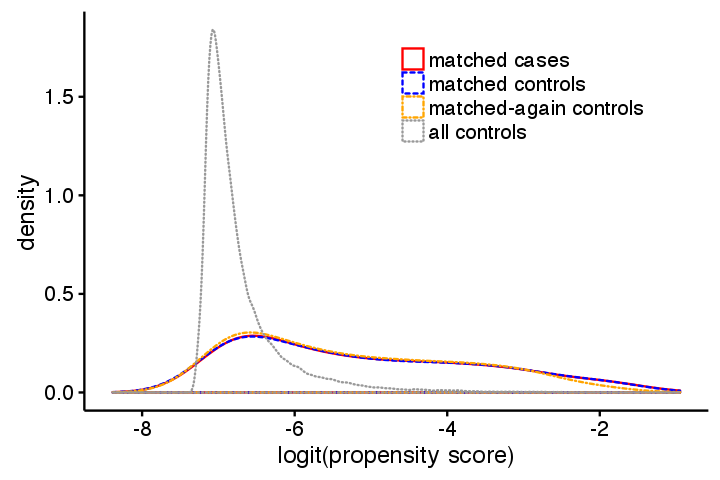

In [230]:
pscores.cdtox_all.HA_early.all_controls <- distances.cdtox_all.HA_early[!df$cdtox_all_bool & matchable.cdtox_all.HA_early]
pscores.cdtox_all.HA_early.m_controls <- distances.cdtox_all.HA_early[m.out.cdtox_all.HA_early.controls]
pscores.cdtox_all.HA_early.m_m_controls <- distances.cdtox_all.HA_early[m.m.out.cdtox_all.HA_early.controls]
pscores.cdtox_all.HA_early.cases <- distances.cdtox_all.HA_early[m.out.cdtox_all.HA_early.cases]

pscores.cdtox_all.HA_early <- data.frame(
    propensity_score = c(pscores.cdtox_all.HA_early.all_controls, pscores.cdtox_all.HA_early.cases, 
                         pscores.cdtox_all.HA_early.m_controls, pscores.cdtox_all.HA_early.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_all.HA_early.all_controls)), 
            rep("matched cases", length(pscores.cdtox_all.HA_early.cases)), 
            rep("matched controls", length(pscores.cdtox_all.HA_early.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_all.HA_early.m_m_controls)))
)

matchit.density(pscores.cdtox_all.HA_early, "cdtox_all-HA_early")
#matchit.freqpoly(pscores.cdtox_all.HA_early, "cdtox_all-HA_early")

## 2c. (1b OR 1c) AND `cdtox_positive_after >= 8`

In [231]:
distances.cdtox_all.HA_late <- as.vector(predict(cvfit.cdtox_all.HA_late, type="response", newx=mat4.no_cdi_equivs, s="lambda.min"))
str(distances.cdtox_all.HA_late)

 num [1:171938] 0.0012 0.00109 0.001 0.00119 0.00108 ...


We forbid matching with:

- any cdtox positive visit that is NOT detected after 8 days.
- any visit (CDI or control) that isn't at least 8 days long.

In [232]:
matchable.cdtox_all.HA_late <- !(
    (cdtox_all_positives & !(df$cdtox_positive_after >= 8))
    | df$length_of_stay < 8
)
sum(matchable.cdtox_all.HA_late)

[1] 26334

The relatively insane `pmin()` at the end is because of one visit that has `length_of_stay` = 7.99 but the `cdtox_positive_after` is ≥8. Gross!

In [233]:
df.no_toxin_after$cdtox_all.HA_late.bool <- df$cdtox_all.HA_late.bool <- cdtox_all_positives & 
                                                                         pmin(df$cdtox_positive_after, df$length_of_stay) >= 8

df.no_toxin_after$matchable.cdtox_all.HA_late <- matchable.cdtox_all.HA_late

Sanity check: All of the cdtox positive visits after 8 days should be matchable.

In [234]:
summary(df.no_toxin_after$cdtox_all.HA_late.bool)
summary(df.no_toxin_after$matchable.cdtox_all.HA_late & df.no_toxin_after$cdtox_all.HA_late.bool)

   Mode   FALSE    TRUE    NA's 
logical  171626     312       0 

   Mode   FALSE    TRUE    NA's 
logical  171626     312       0 

In [235]:
summary(df$length_of_stay[df.no_toxin_after$matchable.cdtox_all.HA_late])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      8      10      13      19      19    1340 

In [236]:
ptm <- proc.time()
m.out.cdtox_all.HA_late <- matchit(cdtox_all.HA_late.bool ~ age_bucket + gender + matchable.cdtox_all.HA_late, 
                                   data=df.no_toxin_after, distance=logit(distances.cdtox_all.HA_late), ratio=1,
                                   exact=c("gender", "age_bucket", "matchable.cdtox_all.HA_late"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 117.98    8.99  127.01 

In [237]:
options(digits=3)
m.out.cdtox_all.HA_late


Call: 
matchit(formula = cdtox_all.HA_late.bool ~ age_bucket + gender + 
    matchable.cdtox_all.HA_late, data = df.no_toxin_after, distance = logit(distances.cdtox_all.HA_late), 
    ratio = 1, exact = c("gender", "age_bucket", "matchable.cdtox_all.HA_late"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171626     312
Matched       235     235
Unmatched  171391      77
Discarded       0       0


In [238]:
head(m.out.cdtox_all.HA_late$match.matrix)

,1
223,3644
903,36344
989,20842
1265,59127
3173,81357
3330,130720


In [281]:
m.out.cdtox_all.HA_late.controls <- as.numeric(m.out.cdtox_all.HA_late$match.matrix[!is.na(m.out.cdtox_all.HA_late$match.matrix)])
m.out.cdtox_all.HA_late.cases <- as.numeric(rownames(m.out.cdtox_all.HA_late$match.matrix)[!is.na(m.out.cdtox_all.HA_late$match.matrix)])
length(m.out.cdtox_all.HA_late.cases) / length(m.out.cdtox_all.HA_late$match.matrix)

[1] 0.75321

In [240]:
df.no_toxin_after$cdtox_all.HA_late.matched <- FALSE
df.no_toxin_after$cdtox_all.HA_late.matched[m.out.cdtox_all.HA_late.controls] <- TRUE

ptm <- proc.time()
m.m.out.cdtox_all.HA_late <- matchit(cdtox_all.HA_late.matched ~ age_bucket + gender + cdtox_all_bool + matchable.cdtox_all.HA_late, 
                                     data=df.no_toxin_after, distance=logit(distances.cdtox_all.HA_late), ratio=1, 
                                     exact=c("gender", "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.HA_late"), caliper=0.2)
proc.time() - ptm

Warning message:
In if (distance %in% c("GAMlogit", "GAMprobit", "GAMcloglog", "GAMlog", : the condition has length > 1 and only the first element will be used

   user  system elapsed 
 113.95    8.04  122.03 

In [241]:
m.m.out.cdtox_all.HA_late.controls <- as.numeric(m.m.out.cdtox_all.HA_late$match.matrix[!is.na(m.m.out.cdtox_all.HA_late$match.matrix)])
m.m.out.cdtox_all.HA_late


Call: 
matchit(formula = cdtox_all.HA_late.matched ~ age_bucket + gender + 
    cdtox_all_bool + matchable.cdtox_all.HA_late, data = df.no_toxin_after, 
    distance = logit(distances.cdtox_all.HA_late), ratio = 1, 
    exact = c("gender", "age_bucket", "cdtox_all_bool", "matchable.cdtox_all.HA_late"), 
    caliper = 0.2)

Sample sizes:
          Control Treated
All        171703     235
Matched       222     222
Unmatched  171481      13
Discarded       0       0


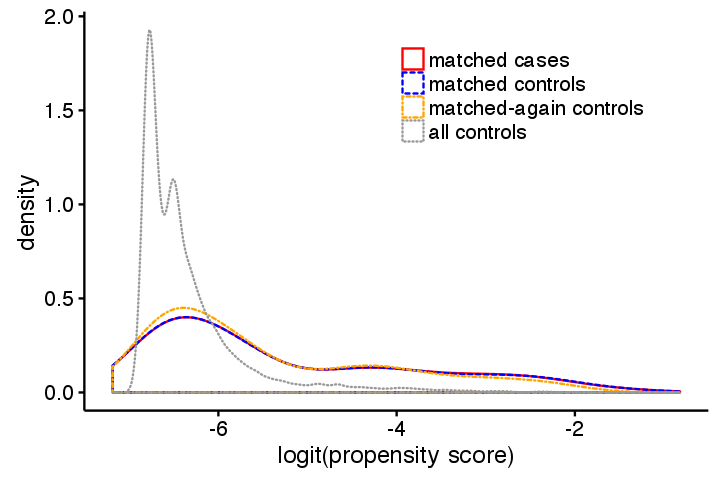

In [242]:
pscores.cdtox_all.HA_late.all_controls <- distances.cdtox_all.HA_late[!df$cdtox_all_bool & matchable.cdtox_all.HA_late]
pscores.cdtox_all.HA_late.m_controls <- distances.cdtox_all.HA_late[m.out.cdtox_all.HA_late.controls]
pscores.cdtox_all.HA_late.m_m_controls <- distances.cdtox_all.HA_late[m.m.out.cdtox_all.HA_late.controls]
pscores.cdtox_all.HA_late.cases <- distances.cdtox_all.HA_late[m.out.cdtox_all.HA_late.cases]

pscores.cdtox_all.HA_late <- data.frame(
    propensity_score = c(pscores.cdtox_all.HA_late.all_controls, pscores.cdtox_all.HA_late.cases, 
                         pscores.cdtox_all.HA_late.m_controls, pscores.cdtox_all.HA_late.m_m_controls),
    set = c(rep("all controls", length(pscores.cdtox_all.HA_late.all_controls)), 
            rep("matched cases", length(pscores.cdtox_all.HA_late.cases)), 
            rep("matched controls", length(pscores.cdtox_all.HA_late.m_controls)),
            rep("matched-again controls", length(pscores.cdtox_all.HA_late.m_m_controls)))
)

matchit.density(pscores.cdtox_all.HA_late, "cdtox_all-HA_late")
#matchit.freqpoly(pscores.cdtox_all.HA_late, "cdtox_all-HA_late")

# Plot summary statistics for matched cohorts

## 1. Comparisons across CDI case definitions

We can go ahead and also examine the distributions of survival times for our matched cohorts. First, we need to go ahead and aggregate the length of stay vs. cohort definition into its own data frame...

In [ ]:
los.parts <- vector("list", 5)
names(los.parts) <- c("cdi_dx", "cdtox_eia", "cdtox_pcr", "cdtox_all", "cdi_union")

for (name in names(los.parts)) {
    case_bool <- df.no_toxin_after[[paste0(name, "_bool")]]
    m.out <- get(paste0("m.out.", name))
    m.out.cases <- get(paste0("m.out.", name, ".cases"))
    m.out.controls <- get(paste0("m.out.", name, ".controls"))
    m.m.out <- get(paste0("m.m.out.", name))
    m.m.out.controls <- get(paste0("m.m.out.", name, ".controls"))
    control_bool <- !case_bool
    if (name == "cdtox_eia") { control_bool <- control_bool & df$started_cdtox_pcr == 'N' }
    else if (name == "cdtox_pcr") { control_bool <- control_bool & df$started_cdtox_pcr == 'Y' }
    los.parts[[name]] <- data.frame(case_def=c(name),
                                    cdi_status=c(rep("all cases", sum(case_bool)), 
                                                 rep("matched cases", length(m.out.cases)),
                                                 rep("matched controls", length(m.out.controls)),
                                                 rep("matched-again controls", length(m.m.out.controls)),
                                                 rep("all controls", sum(control_bool))
                                                ),
                                    df_idx=c(which(case_bool),
                                             m.out.cases,
                                             m.out.controls,
                                             m.m.out.controls,
                                             which(control_bool)
                                            )
                                    )
    los.parts[[name]]$propensity <- get(paste0("distances.", name))[los.parts[[name]]$df_idx]
}

los.df <- do.call(rbind, args=los.parts)
los.df$length_of_stay <- pmax(df$length_of_stay[los.df$df_idx], 0.1)
los.df$age <- df$age[los.df$df_idx]
los.df$age_bucket <- df$age_bucket[los.df$df_idx]
los.df$gender <- df$gender[los.df$df_idx]
los.df$cdtox_positive_after <- pmax(df$cdtox_positive_after[los.df$df_idx], 0)

los.df$cdi_status <- factor(los.df$cdi_status, levels=levels(los.df$cdi_status)[c(3,4,5,1,2)])

In [244]:
options(digits=5)
los.df.agg <- aggregate(length_of_stay ~ case_def + cdi_status, data=los.df, FUN=median)
los.df.agg

case_def,cdi_status,length_of_stay
cdi_dx,matched cases,7.9479
cdtox_eia,matched cases,15.1684
cdtox_pcr,matched cases,12.6979
cdtox_all,matched cases,13.2288
cdi_union,matched cases,11.8868
cdi_dx,matched controls,4.8410
cdtox_eia,matched controls,5.0247
cdtox_pcr,matched controls,6.1417
cdtox_all,matched controls,5.9955
cdi_union,matched controls,6.2229


The following tables create summary statistics for the matched cohorts shown in Table 1 of the manuscript.

In [245]:
table(los.df$case_def, los.df$cdi_status)

           
            matched cases matched controls matched-again controls all cases
  cdi_dx              489              489                    475       582
  cdtox_eia           274              274                    269       324
  cdtox_pcr           493              493                    458       620
  cdtox_all           788              788                    749       944
  cdi_union           945              945                    905      1092
           
            all controls
  cdi_dx          171356
  cdtox_eia        73647
  cdtox_pcr        97351
  cdtox_all       170994
  cdi_union       170846

In [272]:
for (case_def in levels(los.df$case_def)) {
    print(case_def)
    print(table(los.df[los.df$case_def == case_def, c("cdi_status", "gender")]))
    print(round(table(los.df[los.df$case_def == case_def, c("cdi_status", "gender")])[1,] / 
                sum(los.df$case_def == case_def & los.df$cdi_status == "matched cases"), 2))
        print(round(table(los.df[los.df$case_def == case_def, c("cdi_status", "gender")])[5,] / 
                sum(los.df$case_def == case_def & los.df$cdi_status == "all controls"), 2))
}

[1] "cdi_dx"
                        gender
cdi_status               Female Indeterminant   Male NOT AVAILABLE
  matched cases             278             0    211             0
  matched controls          278             0    211             0
  matched-again controls    269             0    206             0
  all cases                 326             0    256             0
  all controls           101638             2  69715             1
       Female Indeterminant          Male NOT AVAILABLE 
         0.57          0.00          0.43          0.00 
       Female Indeterminant          Male NOT AVAILABLE 
         0.59          0.00          0.41          0.00 
[1] "cdtox_eia"
                        gender
cdi_status               Female Indeterminant  Male NOT AVAILABLE
  matched cases             145             0   129             0
  matched controls          145             0   129             0
  matched-again controls    143             0   126             0
  all cases    

In [273]:
for (case_def in levels(los.df$case_def)) {
    print(case_def)
    print(table(los.df[los.df$case_def == case_def, c("cdi_status", "age_bucket")]))
    print(round(table(los.df[los.df$case_def == case_def, c("cdi_status", "age_bucket")])[1,] / 
                sum(los.df$case_def == case_def & los.df$cdi_status == 'matched cases'), 2))
    print(round(table(los.df[los.df$case_def == case_def, c("cdi_status", "age_bucket")])[5,] / 
                sum(los.df$case_def == case_def & los.df$cdi_status == 'all controls'), 2))
}

[1] "cdi_dx"
                        age_bucket
cdi_status               [18,30) [30,45) [45,60) [60,75) [75,90) [90,120)
  matched cases               69      86      90     122     106       16
  matched controls            69      86      90     122     106       16
  matched-again controls      65      85      87     119     103       16
  all cases                   78     105     105     144     126       24
  all controls             22266   38898   37129   43802   26041     3220
 [18,30)  [30,45)  [45,60)  [60,75)  [75,90) [90,120) 
    0.14     0.18     0.18     0.25     0.22     0.03 
 [18,30)  [30,45)  [45,60)  [60,75)  [75,90) [90,120) 
    0.13     0.23     0.22     0.26     0.15     0.02 
[1] "cdtox_eia"
                        age_bucket
cdi_status               [18,30) [30,45) [45,60) [60,75) [75,90) [90,120)
  matched cases               22      26      58      83      70       15
  matched controls            22      26      58      83      70       15
  matched-again

### Differences of `length_of_stay` among matched cohorts

There are clearly differences in the medians, and the CDI cohorts have longer stays.

In [248]:
sapply(names(los.parts), function(case_def) { 
    median(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched cases']) -
    median(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'])
})

cdi_dx cdtox_eia cdtox_pcr cdtox_all cdi_union 
   3.1069   10.1438    6.5562    7.2333    5.6639

In [284]:
require(simpleboot)
sapply(names(los.parts), function(case_def) { 
    boot_diff <- two.boot(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched cases'],
             los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'], median, R=10000)
    boot.ci(boot_diff, conf=0.95, type=c("basic"))
})

,cdi_dx,cdtox_eia,cdtox_pcr,cdtox_all,cdi_union
R,10000,10000,10000,10000,10000
t0,3.1069,10.144,6.5562,7.2333,5.6639
call,"boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))"
basic,"0.9500, 9750.9800, 250.0300, 2.1993, 3.8563","0.9500, 9750.9800, 250.0300, 7.3111, 12.2406","0.9500, 9750.9800, 250.0300, 4.9556, 8.1374","0.9500, 9750.9800, 250.0300, 5.8365, 8.3441","0.9500, 9750.9800, 250.0300, 4.4576, 6.6458"


The EIA (+) cohort shows the largest effect.

We can plot this in a boxplot...

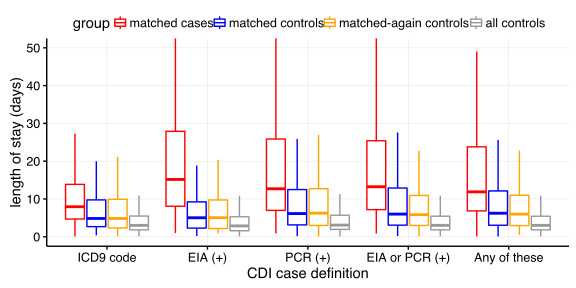

In [250]:
require(cowplot)
options(repr.plot.width=8, repr.plot.height=4)
options(jupyter.plot_mimetypes = "image/svg+xml") 

matchit.pal.dark <- c("darkred", "darkblue", "darkorange", "grey10", "grey20")
labels.case_def <- c("ICD9 code", "EIA (+)", "PCR (+)", "EIA or PCR (+)", "Any of these")

plot.cc_boxplots <- ggplot(los.df[los.df$cdi_status != 'all cases',], 
                           aes(factor(case_def, labels=labels.case_def), length_of_stay)) + 
    geom_boxplot(aes(color=factor(cdi_status)), width=1, position=position_dodge(width=0.85), outlier.shape=NA) + 
    labs(x = "CDI case definition", y = "length of stay (days)", color = "group") + 
    background_grid(major = "xy", minor = "none") +
    coord_cartesian(ylim = c(0, 50)) + 
    scale_colour_manual(values = matchit.pal) +
    theme(legend.position="top")
save_plot("data/analysis_3_match-boxplots.pdf", plot.cc_boxplots, base_aspect_ratio=2)
plot.cc_boxplots

We can use a similar visualization to demonstrate that groups are well matched by `age`

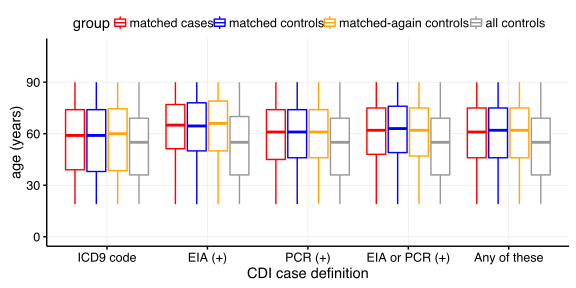

In [251]:
plot.cc_boxplots.age <- ggplot(los.df[los.df$cdi_status != 'all cases',], 
                               aes(factor(case_def, labels=labels.case_def), age)) + 
    geom_boxplot(aes(color=factor(cdi_status)), width=1, position=position_dodge(width=0.85), outlier.shape=NA) + 
    labs(x = "CDI case definition", y = "age (years)", color = "group") + 
    background_grid(major = "xy", minor = "none") +
    coord_cartesian(ylim = c(0, 110)) + 
    scale_colour_manual(values = matchit.pal) +
    theme(legend.position="top")
save_plot("data/analysis_3_match-boxplots-age.pdf", plot.cc_boxplots.age, base_aspect_ratio=2)
plot.cc_boxplots.age

A violinplot provides more information than a boxplot; for instance, it is better at revealing multimodality and skew. Median and IQR can be overlaid to ensure it provides all the same summary statistics as a boxplot.

Warning message:
: position_dodge requires non-overlapping x intervalsWarning message:
: position_dodge requires non-overlapping x intervals

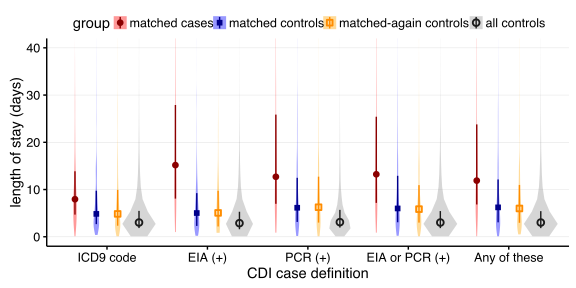

In [252]:
median.quartile <- function(x){
  out <- quantile(x, probs = c(0.25, 0.5, 0.75))
  names(out) <- c("ymin", "y", "ymax")
  return(out) 
}

plot.cc_violins <- ggplot(los.df[los.df$cdi_status != 'all cases',], 
                          aes(factor(case_def, labels=labels.case_def), length_of_stay)) + 
    geom_violin(aes(fill=factor(cdi_status)), alpha=0.4, width=1.35, linetype="blank", 
                position=position_dodge(width=0.85)) + 
    labs(x="CDI case definition", y="length of stay (days)", color="group") + 
    background_grid(major = "y", minor = "none") +
    coord_cartesian(ylim = c(0, 40)) + 
    stat_summary(aes(color=factor(cdi_status), shape=factor(cdi_status)), fun.data=median.quartile,
                 position=position_dodge(width=0.85)) +
    scale_fill_manual(values = matchit.pal, name="group") +
    scale_colour_manual(values = matchit.pal.dark, name="group") +
    scale_shape_manual(values = c(16, 15, 0, 1), name="group") +
    theme(legend.position="top")
save_plot("data/analysis_3_match-violins.pdf", plot.cc_violins, base_aspect_ratio=2)
plot.cc_violins

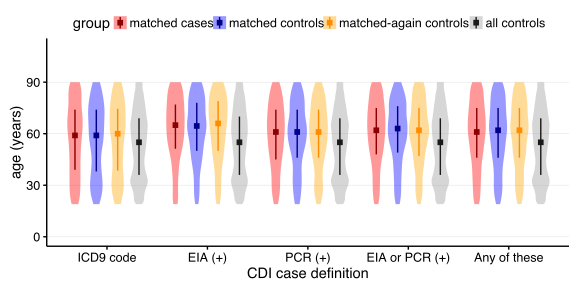

In [253]:
plot.cc_violins.age <- ggplot(los.df[los.df$cdi_status != 'all cases',], 
                              aes(factor(case_def, labels=labels.case_def), age)) + 
    geom_violin(aes(fill=factor(cdi_status)), alpha=0.4, width=0.8, linetype="blank", 
                position=position_dodge(width=0.85)) + 
    labs(x="CDI case definition", y="age (years)", color="group") + 
    background_grid(major = "y", minor = "none") +
    coord_cartesian(ylim = c(0, 110)) + 
    stat_summary(aes(color=factor(cdi_status)), fun.data=median.quartile, shape=15,
                 position=position_dodge(width=0.85)) +
    scale_fill_manual(values = matchit.pal, name="group") +
    scale_colour_manual(values = matchit.pal.dark, name="group") +
    theme(legend.position="top")
save_plot("data/analysis_3_match-violins-age.pdf", plot.cc_violins.age, base_aspect_ratio=2)
plot.cc_violins.age

Significance test on the difference in length of stay between matched cases and matched controls, and matched controls vs matched-again controls, and cases vs matched-again controls, using Wilcoxon rank sum test (a.k.a. Mann-Whitney U).

In [254]:
sapply(levels(los.df$case_def), function(case_def) {
    w <- wilcox.test(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched cases'],
        los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'], conf.int=TRUE)
    w2 <- wilcox.test(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'],
        los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched-again controls'], conf.int=TRUE)
    w3 <- wilcox.test(los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched cases'],
        los.df$length_of_stay[los.df$case_def == case_def & los.df$cdi_status == 'matched-again controls'], conf.int=TRUE)
    list(cases_vs_matched_controls=w$p.value, 
         matched_vs_matched_again_controls=w2$p.value,
         cases_vs_matched_again_controls=w3$p.value)
})

,cdi_dx,cdtox_eia,cdtox_pcr,cdtox_all,cdi_union
cases_vs_matched_controls,1.1154e-14,1.3168e-35,1.6698e-27,4.8008e-50,1.9726e-46
matched_vs_matched_again_controls,0.39869,0.74832,0.85527,0.2483,0.19711
cases_vs_matched_again_controls,5.6158e-16,7.1868e-32,4.972e-27,2.098e-58,2.217e-54


Significance test on the difference in age between matched cases and matched controls, and matched controls vs matched-again controls, and cases vs matched-again controls, using Wilcoxon rank sum test (a.k.a. Mann-Whitney *U*).

In [255]:
sapply(levels(los.df$case_def), function(case_def) {
    w <- wilcox.test(los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched cases'],
        los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'], conf.int=TRUE)
    w2 <- wilcox.test(los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched controls'],
        los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched-again controls'], conf.int=TRUE)
    w3 <- wilcox.test(los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched cases'],
        los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched-again controls'], conf.int=TRUE)
    list(cases_vs_matched_controls=w$p.value,
         matched_vs_matched_again_controls=w2$p.value,
         cases_vs_matched_again_controls=w3$p.value)
})

,cdi_dx,cdtox_eia,cdtox_pcr,cdtox_all,cdi_union
cases_vs_matched_controls,0.85909,0.78748,0.98599,0.97606,0.93418
matched_vs_matched_again_controls,0.94521,0.6247,0.92469,0.85632,0.99184
cases_vs_matched_again_controls,0.7722,0.83849,0.92601,0.8384,0.92902


**Standardized mean differences** in age between matched cases and matched controls, and matched controls vs matched-again controls, and cases vs matched-again controls. (This checks whether matching was balanced on age, which we'd certainly hope since we did coarse exact matching on age.) The formula is from [Austin 2011](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/?tool=pmcentrez).

In [256]:
sapply(levels(los.df$case_def), function(case_def) {
    cases <- los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched cases']
    m.controls <- los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched controls']
    m.m.controls <- los.df$age[los.df$case_def == case_def & los.df$cdi_status == 'matched-again controls']
    
    smd <- (mean(cases) - mean(m.controls)) / sqrt((sd(cases) ^ 2 + sd(m.controls)) / 2)
    smd2 <- (mean(m.controls) - mean(m.m.controls)) / sqrt((sd(m.controls) ^ 2 + sd(m.m.controls)) / 2)
    smd3 <- (mean(cases) - mean(m.m.controls)) / sqrt((sd(cases) ^ 2 + sd(m.m.controls)) / 2)
    
    list(cases_vs_matched_controls=smd, matched_vs_matched_again_controls=smd2, cases_vs_matched_again_controls=smd3)
})

,cdi_dx,cdtox_eia,cdtox_pcr,cdtox_all,cdi_union
cases_vs_matched_controls,0.01628,0.017782,0.0054879,0.0026883,0.0040078
matched_vs_matched_again_controls,0.0091514,-0.037085,0.0020898,0.0030194,0.0018904
cases_vs_matched_again_controls,0.025178,-0.018379,0.0076002,0.0056458,0.0058927


## 2. Stratification across CDI diagnosis time

Same as above, but for these strata instead of the case cohorts.

In [ ]:
los.dx_time.parts <- vector("list", 3)
names(los.dx_time.parts) <- c("cdtox_all.CA", "cdtox_all.HA_early", "cdtox_all.HA_late")

for (name in names(los.dx_time.parts)) {    
    case_bool <- df[[paste0(name, ".bool")]]
    m.out <- get(paste0("m.out.", name))
    m.out.cases <- get(paste0("m.out.", name, ".cases"))
    m.out.controls <- get(paste0("m.out.", name, ".controls"))
    m.m.out <- get(paste0("m.m.out.", name))
    m.m.out.controls <- get(paste0("m.m.out.", name, ".controls"))
    control_bool <- !df$cdtox_all_bool
    matchable_bool <- get(paste0("matchable.", name))
    if (name != "cdtox_all.CA") { control_bool <- control_bool & matchable_bool }
    
    los.dx_time.parts[[name]] <- data.frame(case_def=c(name),
                                            cdi_status=c(rep("all cases", sum(case_bool)), 
                                                         rep("matched cases", length(m.out.cases)),
                                                         rep("matched controls", length(m.out.controls)),
                                                         rep("matched-again controls", length(m.m.out.controls)),
                                                         rep("all controls", sum(control_bool))
                                                        ),
                                            df_idx=c(which(case_bool), 
                                                     m.out.cases,
                                                     m.out.controls,
                                                     m.m.out.controls,
                                                     which(control_bool)
                                                    )
                                            )
    los.dx_time.parts[[name]]$propensity <- get(paste0("distances.", name))[los.dx_time.parts[[name]]$df_idx]
}

los.dx_time.df <- do.call(rbind, args=los.dx_time.parts)
los.dx_time.df$length_of_stay <- pmax(df$length_of_stay[los.dx_time.df$df_idx], 0.1)
los.dx_time.df$age <- df$age[los.dx_time.df$df_idx]
los.dx_time.df$gender <- df$gender[los.dx_time.df$df_idx]
los.dx_time.df$cdtox_positive_after <- pmax(df$cdtox_positive_after[los.dx_time.df$df_idx], 0)

los.dx_time.df$cdi_status <- factor(los.dx_time.df$cdi_status, levels=levels(los.dx_time.df$cdi_status)[c(3,4,5,1,2)])

In [258]:
options(digits=5)
los.dx_time.df.agg <- aggregate(length_of_stay ~ case_def + cdi_status, data=los.dx_time.df, FUN=median)
los.dx_time.df.agg

case_def,cdi_status,length_of_stay
cdtox_all.CA,matched cases,7.0733
cdtox_all.HA_early,matched cases,10.3378
cdtox_all.HA_late,matched cases,28.3007
cdtox_all.CA,matched controls,4.5986
cdtox_all.HA_early,matched controls,7.2465
cdtox_all.HA_late,matched controls,14.3222
cdtox_all.CA,matched-again controls,4.9653
cdtox_all.HA_early,matched-again controls,7.1330
cdtox_all.HA_late,matched-again controls,14.7108
cdtox_all.CA,all cases,7.0622


In [259]:
sapply(names(los.dx_time.parts), function(case_def) { 
    median(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & los.dx_time.df$cdi_status == 'matched cases']) -
    median(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & los.dx_time.df$cdi_status == 'matched controls'])
})

cdtox_all.CA cdtox_all.HA_early  cdtox_all.HA_late 
            2.4747             3.0913            13.9785

In [283]:
require(simpleboot)
sapply(names(los.dx_time.parts), function(case_def) { 
    boot_diff <- two.boot(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                        los.dx_time.df$cdi_status == 'matched cases'],
                          los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                        los.dx_time.df$cdi_status == 'matched controls'], 
                          median, R=10000)
    boot.ci(boot_diff, conf=0.95, type=c("basic"))
})

,cdtox_all.CA,cdtox_all.HA_early,cdtox_all.HA_late
R,10000,10000,10000
t0,2.4747,3.0913,13.978
call,"boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))","boot.ci(boot.out = boot_diff, conf = 0.95, type = c(""basic""))"
basic,"0.9500, 9750.9800, 250.0300, 1.2143, 3.3670","0.9500, 9750.9800, 250.0300, 1.7924, 4.4003","0.9500, 9750.9800, 250.0300, 9.8564, 17.1055"


Warning message:
: position_dodge requires non-overlapping x intervalsWarning message:
: position_dodge requires non-overlapping x intervals

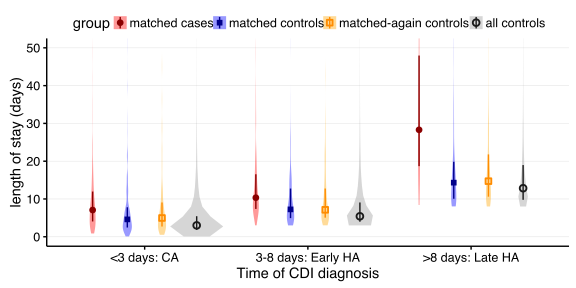

In [261]:
options(jupyter.plot_mimetypes = "image/svg+xml") 
labels.dx_time.case_def <- c("<3 days: CA", "3-8 days: Early HA", ">8 days: Late HA")

plot.cc_violins <- ggplot(los.dx_time.df[los.dx_time.df$cdi_status != 'all cases',], 
                          aes(factor(case_def, labels=labels.dx_time.case_def), length_of_stay)) + 
    geom_violin(aes(fill=factor(cdi_status)), alpha=0.4, width=1.3, linetype="blank", 
                position=position_dodge(width=0.85)) + 
    labs(x="Time of CDI diagnosis", y="length of stay (days)", color="group") + 
    background_grid(major = "y", minor = "none") +
    coord_cartesian(ylim = c(0, 50)) + 
    stat_summary(aes(color=factor(cdi_status), shape=factor(cdi_status)), fun.data=median.quartile,
                 position=position_dodge(width=0.85)) +
    scale_fill_manual(values = matchit.pal, name="group") +
    scale_colour_manual(values = matchit.pal.dark, name="group") +
    scale_shape_manual(values = c(16, 15, 0, 1), name="group") +
    theme(legend.position="top")
save_plot("data/analysis_3_match-dx_times-violins.pdf", plot.cc_violins, base_aspect_ratio=2)
plot.cc_violins

Significance test on the difference in length of stay between cases and matched controls, and matched controls vs matched-again controls, and cases vs matched-again controls, using Wilcoxon rank sum test (a.k.a. Mann-Whitney U).

In [262]:
sapply(levels(los.dx_time.df$case_def), function(case_def) {
    w <- wilcox.test(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                   los.dx_time.df$cdi_status == 'matched cases'],
                     los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                   los.dx_time.df$cdi_status == 'matched controls'], 
                     conf.int=TRUE)
    w2 <- wilcox.test(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                    los.dx_time.df$cdi_status == 'matched controls'],
                      los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                    los.dx_time.df$cdi_status == 'matched-again controls'], 
                      conf.int=TRUE)
    w3 <- wilcox.test(los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                los.dx_time.df$cdi_status == 'matched cases'],
                  los.dx_time.df$length_of_stay[los.dx_time.df$case_def == case_def & 
                                                los.dx_time.df$cdi_status == 'matched-again controls'], 
                  conf.int=TRUE)
    list(cases_vs_matched_controls=w$p.value, 
         matched_vs_matched_again_controls=w2$p.value,
         cases_vs_matched_again_controls=w3$p.value
         )
})

,cdtox_all.CA,cdtox_all.HA_early,cdtox_all.HA_late
cases_vs_matched_controls,2.281e-07,1.0233e-09,5.7993e-28
matched_vs_matched_again_controls,0.27974,0.63605,0.28939
cases_vs_matched_again_controls,0.00012128,3.2925e-08,3.6413e-24


In [263]:
sapply(levels(los.dx_time.df$case_def), function(case_def) {
    w <- wilcox.test(los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                        los.dx_time.df$cdi_status == 'matched cases'],
                     los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                        los.dx_time.df$cdi_status == 'matched controls'], 
                     conf.int=TRUE)
    w2 <- wilcox.test(los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                         los.dx_time.df$cdi_status == 'matched controls'],
                      los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                         los.dx_time.df$cdi_status == 'matched-again controls'], 
                      conf.int=TRUE)
    w3 <- wilcox.test(los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                     los.dx_time.df$cdi_status == 'matched cases'],
                  los.dx_time.df$age[los.dx_time.df$case_def == case_def & 
                                     los.dx_time.df$cdi_status == 'matched-again controls'], 
                  conf.int=TRUE)
    list(cases_vs_matched_controls=w$p.value, 
         matched_vs_matched_again_controls=w2$p.value,
         cases_vs_matched_again_controls=w3$p.value
        )
})

,cdtox_all.CA,cdtox_all.HA_early,cdtox_all.HA_late
cases_vs_matched_controls,0.98239,0.99642,0.91533
matched_vs_matched_again_controls,0.80494,0.99129,0.97258
cases_vs_matched_again_controls,0.82458,0.9933,0.87217


# Side quest

Does propensity score directly correlate with length of stay? It might be interesting if there is a proportional relationship between CDI risk and LOS.

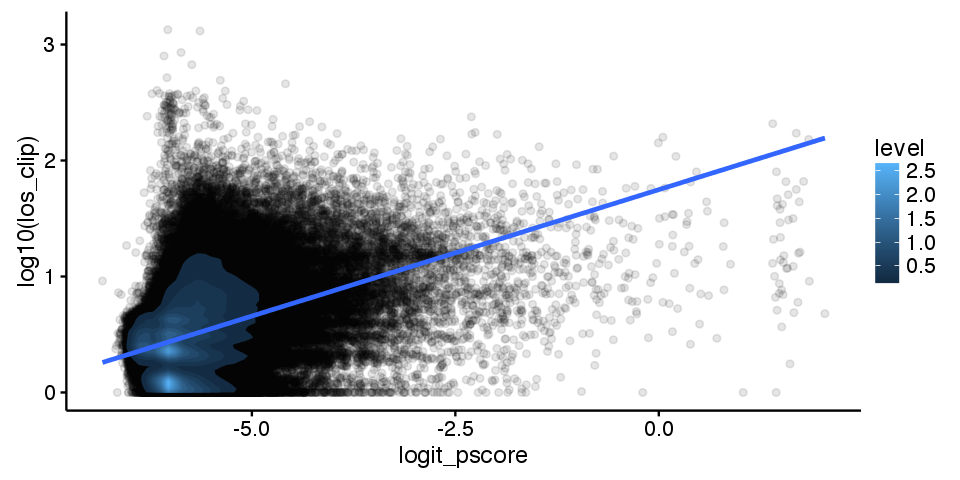

In [264]:
require(ggplot2)
require(cowplot)
options(jupyter.plot_mimetypes = "image/png", repr.plot.bg='white')
df.fun <- df
df.fun$logit_pscore <- log(distances.cdtox_all / (1 - distances.cdtox_all))
df.fun$los_clip <- pmax(df$length_of_stay, 1)
ggplot(df.fun, aes(x = logit_pscore, y = log10(los_clip))) +
    geom_point(alpha = 0.1) +
    stat_density2d(aes(fill = ..level..), geom = "polygon") +
    geom_smooth(method='lm', formula=y~x)

It does indeed, although it's a weak correlation, and certainly nothing can be said about the direction of causality here. Certainly, there are many patients with low CDI risk that ended up with very long LOS (top left).

In [265]:
df.fun$log10_los_clip <- log10(df.fun$los_clip)
cor(df.fun[c("logit_pscore", "log10_los_clip")])

,logit_pscore,log10_los_clip
logit_pscore,1.00000,0.37693
log10_los_clip,0.37693,1.00000


In [266]:
summary(lm(log10_los_clip ~ logit_pscore, data=df.fun))


Call:
lm(formula = log10_los_clip ~ logit_pscore, data = df.fun)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0630 -0.2753 -0.0174  0.2010  2.6941 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.74858    0.00730     240   <2e-16 ***
logit_pscore  0.21798    0.00129     169   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.349 on 171936 degrees of freedom
Multiple R-squared:  0.142,	Adjusted R-squared:  0.142 
F-statistic: 2.85e+04 on 1 and 171936 DF,  p-value: <2e-16


# Save everything

## save all the R data for the matches

In [267]:
ls()

[1] "alpha"                                  
  [2] "alphas"                                 
  [3] "case_bool"                              
  [4] "case_def"                               
  [5] "cdtox_all_positives"                    
  [6] "control_bool"                           
  [7] "cvfit.cdi_dx"                           
  [8] "cvfit.cdi_union"                        
  [9] "cvfit.cdtox_all"                        
 [10] "cvfit.cdtox_all.CA"                     
 [11] "cvfit.cdtox_all.HA_early"               
 [12] "cvfit.cdtox_all.HA_late"                
 [13] "cvfit.cdtox_eia"                        
 [14] "cvfit.cdtox_pcr"                        
 [15] "cvfits.cdi_dx"                          
 [16] "df"                                     
 [17] "df.fun"                                 
 [18] "df.no_toxin_after"                      
 [19] "distances.cdi_dx"                       
 [20] "distances.cdi_union"                    
 [21] "distances.cdtox_all"                    
 [22] "distances.cdtox_all.CA"                 
 [23] "distances.cdtox_all.HA_early"           
 [24] "distances.cdtox_all.HA_late"            
 [25] "distances.cdtox_eia"                    
 [26] "distances.cdtox_pcr"                    
 [27] "dx.df"                                  
 [28] "eligible.cdtox_all.CA"                  
 [29] "eligible.cdtox_all.HA_early"            
 [30] "eligible.cdtox_all.HA_late"             
 [31] "foldid"                                 
 [32] "foldid.cdtox_all.CA"                    
 [33] "foldid.cdtox_all.HA_early"              
 [34] "foldid.cdtox_all.HA_late"               
 [35] "foldid.cdtox_eia"                       
 [36] "foldid.cdtox_pcr"                       
 [37] "labels.case_def"                        
 [38] "labels.dx_time.case_def"                
 [39] "los.df"                                 
 [40] "los.df.agg"                             
 [41] "los.dx_time.df"                         
 [42] "los.dx_time.df.agg"                     
 [43] "los.dx_time.m.df"                       
 [44] "los.dx_time.parts"                      
 [45] "los.m.df"                               
 [46] "los.parts"                              
 [47] "m.m.out"                                
 [48] "m.m.out.cdi_dx"                         
 [49] "m.m.out.cdi_dx.controls"                
 [50] "m.m.out.cdi_union"                      
 [51] "m.m.out.cdi_union.controls"             
 [52] "m.m.out.cdtox_all"                      
 [53] "m.m.out.cdtox_all.CA"                   
 [54] "m.m.out.cdtox_all.CA.controls"          
 [55] "m.m.out.cdtox_all.controls"             
 [56] "m.m.out.cdtox_all.HA_early"             
 [57] "m.m.out.cdtox_all.HA_early.controls"    
 [58] "m.m.out.cdtox_all.HA_late"              
 [59] "m.m.out.cdtox_all.HA_late.controls"     
 [60] "m.m.out.cdtox_eia"                      
 [61] "m.m.out.cdtox_eia.controls"             
 [62] "m.m.out.cdtox_pcr"                      
 [63] "m.m.out.cdtox_pcr.controls"             
 [64] "m.m.out.controls"                       
 [65] "m.out"                                  
 [66] "m.out.cases"                            
 [67] "m.out.cdi_dx"                           
 [68] "m.out.cdi_dx.cases"                     
 [69] "m.out.cdi_dx.controls"                  
 [70] "m.out.cdi_union"                        
 [71] "m.out.cdi_union.cases"                  
 [72] "m.out.cdi_union.controls"               
 [73] "m.out.cdtox_all"                        
 [74] "m.out.cdtox_all.CA"                     
 [75] "m.out.cdtox_all.CA.cases"               
 [76] "m.out.cdtox_all.CA.controls"            
 [77] "m.out.cdtox_all.cases"                  
 [78] "m.out.cdtox_all.controls"               
 [79] "m.out.cdtox_all.HA_early"               
 [80] "m.out.cdtox_all.HA_early.cases"         
 [81] "m.out.cdtox_all.HA_early.controls"      
 [82] "m.out.cdtox_all.HA_late"                
 [83] "m.out.cdtox_all.HA_late.cases"          
 [84] "m.out.cdtox

Save vital (expensive to generate) data into a smaller `.RData` file

In [268]:
save(m.out.cdi_dx, m.m.out.cdi_dx,
     m.out.cdtox_eia, m.m.out.cdtox_eia,
     m.out.cdtox_pcr, m.m.out.cdtox_pcr,
     m.out.cdtox_all, m.m.out.cdtox_all,
     m.out.cdi_union, m.m.out.cdi_union,
     m.out.cdtox_all.CA, m.m.out.cdtox_all.CA,
     m.out.cdtox_all.HA_early, m.m.out.cdtox_all.HA_early,
     m.out.cdtox_all.HA_late, m.m.out.cdtox_all.HA_late,
     file="data/analysis_3_matchit.RData")

Save the entire workspace for posterity

In [269]:
save.image(file="data/analysis_3_matchit.all.RData")

## save data for `survival`, `etm` analysis

Previously we limited this to cases and matched controls, but after adding the analysis with `etm`, we need the data for all controls.

Therefore the next step is a superfluous rename.

In [270]:
los.m.df <- los.df                  #[los.df$cdi_status %in% c("cases", "matched controls"),]
los.dx_time.m.df <- los.dx_time.df  #[los.dx_time.df$cdi_status %in% c("cases", "matched controls"),]

In [271]:
write.table(los.m.df, file="data/analysis_3_matchit-los-m-df.tsv", quote=FALSE, sep="\t", row.names=FALSE)
write.table(los.dx_time.m.df, file="data/analysis_3_matchit-los-dxtime-m-df.tsv", quote=FALSE, sep="\t", row.names=FALSE)

save(los.m.df, file="data/analysis_3_matchit-los-m-df.RData")
save(los.dx_time.m.df, file="data/analysis_3_matchit-los-dxtime-m-df.RData")